In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt


In [3]:
'''创建8个相关数据组，并引入超先验'''
n = 20 
m = 8
idx = np.repeat(range(m-1), n)
idx = np.append(idx, 7)

alpha_real = np.random.normal(2.5, 0.5, size=m)
beta_real = np.random.beta(60, 10, size=m)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real


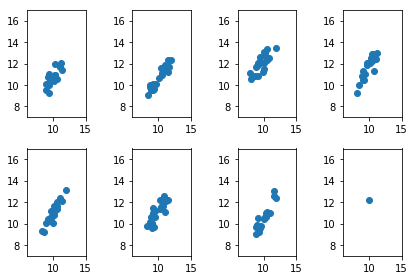

In [4]:
j, k = 0, n
for i in range(m):
    plt.subplot(2, 4, i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += n
    k += n
plt.tight_layout()

x_centered = x_m - x_m.mean()

1


C:\Users\Forry\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -155.04, ||grad|| = 0.84097: 100%|█████████████████████████████████████████████| 81/81 [00:00<00:00, 920.50it/s]


2
3


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha_tmp]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 469.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022A3E3FA9E8>,
      dtype=object)

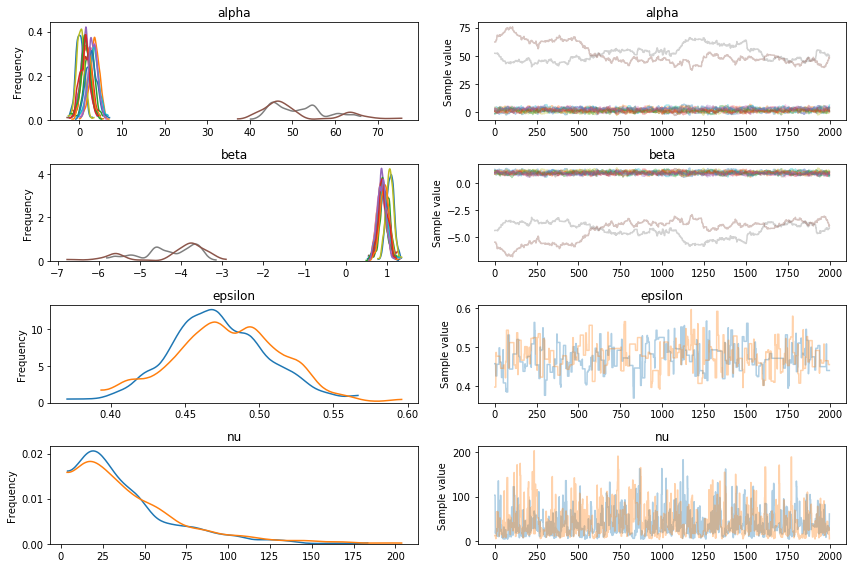

In [8]:
'''非多层模型'''

with pm.Model() as model_f:
    #设置先验
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=m)
    beta = pm.Normal('beta', mu=0, sd=10, shape=m)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    nu = pm.Exponential('nu', 1/30)
    
    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered,
                        sd = epsilon, nu=nu, observed=y_m)
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean())
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_up = pm.sample(2000, step=step, start=start)

varnames = ['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames)

In [13]:
'''多层模型'''

with pm.Model() as model_j:
    #设置超先验
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)
    
    #设置先验
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=m)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    
    y_pred = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean())
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    mu, sds, elbo = pm.variational.advi(n=100000, verbose=False)
    col_scal = np.power(model_j.dict_to_array(sds), 2)
    step = pm.NUTS(scaling=cov_scal, is_cov=True)
    trace_hm = pm.sample(1000, step=step, start=mu)

varnames = ['alpha', 'alpha_mu', 'alpha_sd', 'beta', 'beta_mu', 'beta_sd', 
           'epsilon', 'nu']
pm.traceplot(trace_hm, varnames)
    
    

AttributeError: module 'pymc3.variational' has no attribute 'advi'